In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
data.duplicated().sum()

686

In [5]:
data.drop_duplicates(inplace= True)

In [91]:
def tokenize(sentence: str) -> list:
    tokens = word_tokenize(sentence)
    return tokens

def remove_stopwords(tokens: list) -> str:
    stop_words = set(stopwords.words('english'))
    tokens_wo_stop_words = [token for token in tokens if token not in stop_words]
    # out = " ".join(tokens_wo_stop_words)
    return tokens_wo_stop_words

def lemmatize(tokens: list) -> list:
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_words

def stemming(tokens: list) -> list:
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(token) for token in tokens]
    return stemmed_words

In [92]:
data['tokens'] = data['text'].apply(tokenize)
data['tokens_stemm'] = data['tokens'].apply(stemming).apply(remove_stopwords)
data['tokens_lemma'] = data['tokens'].apply(lemmatize).apply(remove_stopwords)
# data['tokens_stemm'] = data['tokens_stemm'].apply(tokenize)
# data['tokens_lemma'] = data['tokens_lemma'].apply(tokenize)

In [93]:
data.head(10)

,text,label,tokens,tokens_stemm,tokens_lemma
0,i just feel really helpless and heavy hearted,4,"[i, just, feel, really, helpless, and, heavy, ...","[feel, realli, helpless, heavi, heart]","[feel, really, helpless, heavy, hearted]"
1,ive enjoyed being able to slouch about relax a...,0,"[ive, enjoyed, being, able, to, slouch, about,...","[ive, enjoy, abl, slouch, relax, unwind, frank...","[ive, enjoyed, able, slouch, relax, unwind, fr..."
2,i gave up my internship with the dmrg and am f...,4,"[i, gave, up, my, internship, with, the, dmrg,...","[gave, internship, dmrg, feel, distraught]","[gave, internship, dmrg, feeling, distraught]"
3,i dont know i feel so lost,0,"[i, dont, know, i, feel, so, lost]","[dont, know, feel, lost]","[dont, know, feel, lost]"
4,i am a kindergarten teacher and i am thoroughl...,4,"[i, am, a, kindergarten, teacher, and, i, am, ...","[kindergarten, teacher, thoroughli, weari, job...","[kindergarten, teacher, thoroughly, weary, job..."
5,i was beginning to feel quite disheartened,0,"[i, was, beginning, to, feel, quite, dishearte...","[wa, begin, feel, quit, dishearten]","[wa, beginning, feel, quite, disheartened]"
6,i would think that whomever would be lucky eno...,2,"[i, would, think, that, whomever, would, be, l...","[would, think, whomev, would, lucki, enough, s...","[would, think, whomever, would, lucky, enough,..."
7,i fear that they won t ever feel that deliciou...,1,"[i, fear, that, they, won, t, ever, feel, that...","[fear, ever, feel, delici, excit, christma, ev...","[fear, ever, feel, delicious, excitement, chri..."
8,im forever taking some time out to have a lie ...,5,"[im, forever, taking, some, time, out, to, hav...","[im, forev, take, time, lie, becaus, feel, weird]","[im, forever, taking, time, lie, feel, weird]"
9,i can still lose the weight without feeling de...,0,"[i, can, still, lose, the, weight, without, fe...","[still, lose, weight, without, feel, depriv]","[still, lose, weight, without, feeling, deprived]"


In [312]:
data = data[~(data['tokens_stemm'].apply(len) == 0)]

In [313]:
data.to_csv("data_w_stem_lemm.csv")

In [95]:
def get_max_len(column: pd.Series):
    max_len = 0
    for index, item in column.items():
        length = len(item)
        if length > max_len:
            max_len = length
    return max_len

def get_unique_words(column: pd.Series):
    unique_words = set()
    for index, item in column.items():
        [unique_words.add(word) for word in item if word not in unique_words]
        
    return len(unique_words)

In [96]:
print(get_max_len(data['tokens_stemm']))
print(get_max_len(data['tokens_lemma']))
print(get_unique_words(data['tokens_stemm']))
print(get_unique_words(data['tokens_lemma']))

82
80
51797
67592


In [524]:
data2 = data.iloc[:100000]

In [525]:
len(data)

416113

In [526]:
len(data2)

100000

In [541]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# 0.125 x 0.8 = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [542]:
train_data = pd.concat((X_train,y_train), axis=1).reset_index()
val_data = pd.concat((X_val,y_val), axis=1).reset_index()
test_data = pd.concat((X_test,y_test), axis=1).reset_index()

In [543]:
tokenizer = Tokenizer(num_words=52000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [544]:
tokenizer.texts_to_sequences(['<OOV>'])

[[1]]

In [545]:
def pad_sequence(sequence: list, max_len:int = 100):
    seq = tokenizer.texts_to_sequences(sequence)
    seq = [sub_seq if sub_seq != [] else [1] for sub_seq in seq]
    try:
        seq_ten = torch.tensor(seq).flatten()
        out_ten = torch.zeros(size= (max_len,)).long()
        out_ten[:seq_ten.size(0)] = seq_ten
        return out_ten
    except ValueError:
        print(seq)
        return torch.zeros(size= (max_len,)).long()

In [546]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence)
val_data['padded'] = val_data['tokens_stemm'].apply(pad_sequence)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence)
train_data.head()

,index,tokens_stemm,label,padded
0,216356,"[im, feel, virtuou, avoid, chip, aisl, altogeth]",1,"[tensor(4), tensor(2), tensor(699), tensor(849..."
1,69696,"[im, quit, certain, im, tough, time, battl, th...",3,"[tensor(4), tensor(74), tensor(600), tensor(4)..."
2,196326,"[wasnt, feel, quit, thi, appreci, howev, shove...",1,"[tensor(249), tensor(2), tensor(74), tensor(6)..."
3,207657,"[feel, disgust]",3,"[tensor(2), tensor(376), tensor(0), tensor(0),..."
4,31333,"[feel, fuck, dumb]",0,"[tensor(2), tensor(226), tensor(528), tensor(0..."


In [547]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe[["padded","label"]]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        output = self.dataframe.iloc[index]
        return {
            "padded": output['padded'],
            "label": output['label']
        }

In [548]:
X_train_dataset = PandasDataset(train_data)
X_val_dataset = PandasDataset(val_data)
X_test_dataset = PandasDataset(test_data)

In [552]:
X_train_batched = DataLoader(X_train_dataset, batch_size= 256)
X_val_batched = DataLoader(X_val_dataset, batch_size= 64)
X_test_batched = DataLoader(X_test_dataset, batch_size= 64)

In [500]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
        
class CNNTextClassifier(nn.Module):
    def __init__(self, 
                 vocab_size:int = 52000, 
                 embedding_dim:int = 16, 
                 input_length:int = 100, 
                 num_filters:int = 128, 
                 kernel_size:int = 5, 
                 hidden_units:int = 64, 
                 num_classes:int = 6):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=input_length - kernel_size + 1)
        self.fc1 = nn.Linear(num_filters, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
        self.apply(init_weights)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change shape for Conv1D
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.squeeze(2)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
        
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 128,
                hidden_size:int = 64,
                num_layers:int = 1,
                output_size:int = 6,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=52000, embedding_dim= input_size)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1),
        )
        
        self.apply(init_weights)
        
    def forward(self, x: torch.TensorType):
        emb = self.embedding(x)
        
        # bilstm
        for i in range(emb.size(-2)):
            if i == 0:
                lstm_out, (hidden,cell) = self.bilstm(emb[:,i,:])
            else:
                lstm_out, (hidden,cell) = self.bilstm(emb[:,i,:], (hidden,cell))

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [369]:
from tqdm import tqdm
import math

In [536]:
def train(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
    # import math
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    start_lr = learning_rate * 100
    end_lr = learning_rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    
    # lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / num_epochs * len(train_dataloader))
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    epoch_loss, epoch_acc = [], []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct_predictions = 0
        train_total_predictions = 0
        
        for batch in tqdm(train_dataloader):
            inputs = batch['padded'].to(device)
            labels = batch['label'].to(device)
            # print(inputs.size())
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            train_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            train_correct_predictions += (predicted == labels).sum().item()
            train_total_predictions += labels.size(0)
        
        train_epoch_loss = train_running_loss / len(train_dataloader.dataset)
        train_epoch_accuracy = train_correct_predictions / train_total_predictions
        
        # Validation phase
        model.eval()
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                val_inputs = batch['padded'].to(device)
                val_labels = batch['label'].to(device)
                
                val_outputs = model(val_inputs)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_predictions += val_labels.size(0)
        
        val_epoch_accuracy = val_correct_predictions / val_total_predictions
        
        epoch_loss.append(train_epoch_loss)
        epoch_acc.append(val_epoch_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, '
              f'Val Accuracy: {val_epoch_accuracy:.4f}')
        
    return epoch_loss, epoch_acc

In [553]:
model = CNNTextClassifier()

In [554]:
losses, accuracies = train(model, X_train_batched, X_val_batched, 15, 0.001)

  0%|          | 1/1138 [00:00<02:40,  7.10it/s]

Epoch 1/15, Train Loss: 1.5205, Train Accuracy: 0.5183, Val Accuracy: 0.6602


  0%|          | 1/1138 [00:00<03:15,  5.81it/s]

Epoch 2/15, Train Loss: 1.2890, Train Accuracy: 0.7552, Val Accuracy: 0.8111


  0%|          | 1/1138 [00:00<02:28,  7.66it/s]

Epoch 3/15, Train Loss: 1.1993, Train Accuracy: 0.8450, Val Accuracy: 0.8546


  0%|          | 1/1138 [00:00<02:23,  7.92it/s]

Epoch 4/15, Train Loss: 1.1701, Train Accuracy: 0.8731, Val Accuracy: 0.8717


  0%|          | 1/1138 [00:00<02:42,  7.00it/s]

Epoch 5/15, Train Loss: 1.1596, Train Accuracy: 0.8838, Val Accuracy: 0.8762


  0%|          | 1/1138 [00:00<03:04,  6.16it/s]

Epoch 6/15, Train Loss: 1.1540, Train Accuracy: 0.8894, Val Accuracy: 0.8792


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 1.1508, Train Accuracy: 0.8926, Val Accuracy: 0.8812


  0%|          | 1/1138 [00:00<02:32,  7.46it/s]

Epoch 8/15, Train Loss: 1.1466, Train Accuracy: 0.8968, Val Accuracy: 0.8901


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 1.1359, Train Accuracy: 0.9079, Val Accuracy: 0.8965


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 1.1318, Train Accuracy: 0.9118, Val Accuracy: 0.8985


  0%|          | 1/1138 [00:00<03:04,  6.16it/s]

Epoch 11/15, Train Loss: 1.1291, Train Accuracy: 0.9144, Val Accuracy: 0.8983


  0%|          | 1/1138 [00:00<02:24,  7.86it/s]

Epoch 12/15, Train Loss: 1.1265, Train Accuracy: 0.9168, Val Accuracy: 0.8991


  0%|          | 1/1138 [00:00<02:41,  7.06it/s]

Epoch 13/15, Train Loss: 1.1246, Train Accuracy: 0.9188, Val Accuracy: 0.9003


  0%|          | 1/1138 [00:00<02:43,  6.96it/s]

Epoch 14/15, Train Loss: 1.1239, Train Accuracy: 0.9194, Val Accuracy: 0.9017


100%|██████████| 1138/1138 [02:39<00:00,  7.14it/s]


Epoch 15/15, Train Loss: 1.1226, Train Accuracy: 0.9208, Val Accuracy: 0.9016


In [539]:
def confusion_matrix(y_pred, y_true, num_classes):
    """
    Create a confusion matrix for label encodings in PyTorch.

    Parameters:
    y_pred (torch.Tensor): Predicted labels tensor.
    y_true (torch.Tensor): True labels tensor.
    num_classes (int): Number of classes.

    Returns:
    numpy.ndarray: Confusion matrix.
    """ 
    # if len(y_pred) != len(y_true):
    #     raise ValueError("Shapes of predictions and true labels must match. y_pred shape: {} y_true shape: {}".format(y_pred.shape, y_true.shape))

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_pred_np = y_pred.argmax(dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    for pred, true in zip(y_pred_np, y_true_np):
        conf_matrix[pred, true] += 1

    return conf_matrix

def calculate_confusion_matrix(test_emb, test_labels, model):
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, 6)

def class_accuracy(conf_matrix):
    """
    Calculate accuracy for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.

    Returns:
    list: List of accuracies for each class.
    """
    # diagonal = np.diag(conf_matrix)

    # row_sums = conf_matrix.sum(axis=1)

    # accuracies = diagonal / row_sums.astype(float)

    # return accuracies
    
    diagonal = np.diag(conf_matrix)
    row_sums = conf_matrix.sum(axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        accuracies = np.where(row_sums != 0, diagonal / row_sums.astype(float), 0.0)

    return accuracies

def class_f1_score(conf_matrix, epsilon=1e-7):
    """
    Calculate F1 score for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.
    epsilon (float): Smoothing term to avoid division by zero.

    Returns:
    list: List of F1 scores for each class.
    """
    
    tp = np.diag(conf_matrix)
    fp = conf_matrix.sum(axis=0) - tp
    fn = conf_matrix.sum(axis=1) - tp

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1_scores

In [555]:
cm = None
for batch in tqdm(X_test_batched):
    inputs = batch['padded']
    labels = batch['label']
    cm_helper = calculate_confusion_matrix(inputs, labels, model)
    if cm is None:
        cm = cm_helper
    else:
        cm = np.add(cm, cm_helper)
    
accuracies = class_accuracy(cm)
f1_scores = class_f1_score(cm)
average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Accuracies: {accuracies} \n Average acccuracy: {average_accuracy*100:.2f}%")
print(f"F1 Scores: {f1_scores} \n Average F1: {average_f1*100:.2f}%")
    

  0%|          | 0/1301 [00:00<?, ?it/s]

100%|██████████| 1301/1301 [00:34<00:00, 37.93it/s]

Accuracies: [0.9238047  0.90075722 0.87041241 0.91210746 0.91165872 0.74483028] 
 Average acccuracy: 87.73%
F1 Scores: [0.94925082 0.92756218 0.75259666 0.90526218 0.86510033 0.6970969 ] 
 Average F1: 84.95%


In [578]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix):
    labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
    
    plt.figure(figsize=(7,7))
    plt.imshow(conf_matrix, cmap='coolwarm', interpolation='nearest', vmax=3000)
    plt.colorbar()
    
    plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.show()

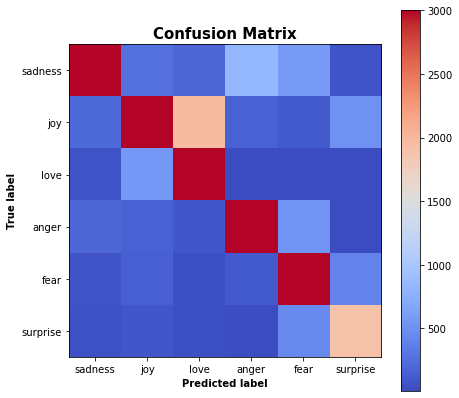

In [579]:
plot_confusion_matrix(cm)